<a href="https://colab.research.google.com/github/zufchan/PINNs-for-Stefan/blob/main/2d1p_Test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import timeit


class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.uniform(0, 1,
                                                                                                  size=(N, self.dim))
        y = self.func(x)
        return x, y


class DataSampler:
    # Initialize the class
    def __init__(self, X, Y, name=None):
        self.X = X
        self.Y = Y
        self.N = self.X.shape[0]

    def sample(self, batch_size):
        idx = np.random.choice(self.N, batch_size, replace=True)
        X_batch = self.X[idx, :]
        Y_batch = self.Y[idx, :]
        return X_batch, Y_batch


class Stefan2D_direct:
    def __init__(self, layers_u, layers_s, ics_sampler, bcs_sampler, res_sampler):
        # Normalization constants
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]
        self.mu_y, self.sigma_y = self.mu_X[1], self.sigma_X[1]
        self.mu_t, self.sigma_t = self.mu_X[2], self.sigma_X[2]

        self.error_s_list = [] 
        self.error_u_list = []

        # Samplers
        self.ics_sampler = ics_sampler
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        # Initialize network weights and biases
        with tf.variable_scope('layers'):
          self.layers_u = layers_u

          self.weights_u, self.biases_u = self.initialize_NN(layers_u)
          
          # Initialize encoder weights and biases
          self.layers_s = layers_s
          self.weights_s, self.biases_s = self.initialize_NN(layers_s)

        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

        with tf.variable_scope('input'):
        # Define placeholders and computational graph
          self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))  
          self.y_u_tf = tf.placeholder(tf.float32, shape=(None, 1))  
          self.t_u_tf = tf.placeholder(tf.float32, shape=(None, 1)) 
          self.u_tf = tf.placeholder(tf.float32, shape=(None, 1)) 
          self.s_tf = tf.placeholder(tf.float32, shape=(None, 1))

        #with tf.variable_scope('boundary_conditions_1'):
          self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.y_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.u_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))

        #with tf.variable_scope('boundary_conditions_2'):
          self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.y_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.u_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        
        #with tf.variable_scope('boundary_conditions_3'):
          self.x_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.y_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.t_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.u_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))

        #with tf.variable_scope('initial_conditions'):
          self.x_0_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.y_0_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.t_0_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.u_0_tf = tf.placeholder(tf.float32, shape=(None, 1))  
          self.s_0_tf = tf.placeholder(tf.float32, shape=(None, 1))  

        #with tf.variable_scope('Normalization_constants'):
          self.y_Nc_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.t_Nc_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.u_Nc_tf = tf.placeholder(tf.float32, shape=(None, 1))

        #with tf.variable_scope('residual_conditions'):
          self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.y_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
          self.t_r_tf = tf.placeholder(tf.float32, shape=(None, 1))


        # Evaluate predictions
        self.s_pred = self.net_s(self.y_u_tf, self.t_u_tf)
        self.s_0_pred = self.net_s(self.y_0_tf, self.t_0_tf)

        self.u_pred = self.net_u(self.x_u_tf, self.y_u_tf, self.t_u_tf)
        self.u_0_pred = self.net_u(self.x_0_tf, self.y_0_tf, self.t_0_tf)

        self.u_bc1_pred = self.net_u(self.x_bc1_tf, self.y_bc1_tf, self.t_bc1_tf)
        self.u_bc2_pred = self.net_u(self.x_bc2_tf, self.y_bc2_tf, self.t_bc2_tf)
        self.u_bc3_pred = self.net_u(self.x_bc3_tf, self.y_bc3_tf, self.t_bc3_tf)
        
        self.S_bc_pred = self.net_u((self.s_pred - self.mu_x) / self.sigma_x,
                                    self.y_u_tf,
                                    self.t_u_tf)
        self.r_Nc_pred = self.net_r_Nc(self.y_Nc_tf, self.t_Nc_tf)
        self.r_u_pred = self.net_r_u(self.x_r_tf, self.y_r_tf, self.t_r_tf)

        # Stefan Boundary loss
        with tf.variable_scope('loss'):
          self.loss_Sbc = tf.reduce_mean(tf.square(self.S_bc_pred))
          self.loss_s_0 = tf.reduce_mean(tf.square(self.s_0_pred - (0.5 * (self.y_0_tf * self.sigma_y + self.mu_y) + 0.5))) # s(y, 0) = y/2   + 1/2
          self.loss_SNc = tf.reduce_mean(tf.square(self.r_Nc_pred))

          # Boundary and Initial loss
          self.loss_u_bc1 = tf.reduce_mean(tf.square(self.u_bc1_pred- self.u_bc1_tf))
          self.loss_u_bc2 = tf.reduce_mean(tf.square(self.u_bc2_pred- self.u_bc2_tf))
          self.loss_u_bc3 = tf.reduce_mean(tf.square(self.u_bc3_pred- self.u_bc3_tf))
          self.loss_u_ic = tf.reduce_mean(tf.square(self.u_0_pred - self.u_0_tf))
          
          self.loss_u_bcs = self.loss_u_bc1 + self.loss_u_bc2 + self.loss_u_bc3
          # Stefan loss
          self.loss_Scs = self.loss_Sbc + self.loss_s_0 + self.loss_SNc

          # Residual loss
          self.loss_res = tf.reduce_mean(tf.square(self.r_u_pred))  # u_t - u_xx = 0

          # Total loss
          self.loss = self.loss_u_bcs + self.loss_u_ic + self.loss_Scs + self.loss_res

        with tf.variable_scope('residual_conditions'):
          tf.summary.scalar('loss', self.loss)
          tf.summary.histogram(name="distribution", values=self.loss)
          tf.summary.scalar('loss_SNc', self.loss_SNc)
          tf.summary.scalar('loss_s_0', self.loss_s_0)
          tf.summary.scalar('loss_u_bcs', self.loss_u_bcs)
          tf.summary.scalar('loss_u_ic', self.loss_u_ic)
          tf.summary.scalar('loss_res', self.loss_res)
          self.summary = tf.summary.merge_all()
        
        # Define optimizer with learning rate schedule
        with tf.variable_scope('train'):
          self.global_step = tf.Variable(0, trainable=False)
          starter_learning_rate = 1e-3
          self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                          1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step
          self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        self.loss_u_bcs_log = []
        self.loss_u_ic_log = []
        self.loss_res_log = []
        self.saver = tf.train.Saver()
        
        # Estimate the accuracy in the training
        x = np.linspace(0, 2.25, 100)[:, None]
        y = np.linspace(0, 1, 100)[:, None]
        t = np.linspace(0, 1, 100)[:, None]
        y, t = np.meshgrid(y, t)

        self.X_star = np.hstack((y.flatten()[:, None], t.flatten()[:, None]))
        self.s_star = self.exact_s(self.X_star)

        self.X_star_u = []
        self.u_star = []
        for T in [0.2, 0.4, 0.6, 0.8]:
          X, Y = np.meshgrid(x, y)
          T_star = T * np.ones_like(X)
          X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T_star.flatten()[:, None]))
          
          u_star = self.exact_u(X_star)
          self.X_star_u.append(X_star)
          self.u_star.append(self.exact_u(X_star))

        self.u_star = np.array(self.u_star).flatten()

        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)
        self.training_writer = tf.summary.FileWriter('./logs/training', self.sess.graph)
        #self.testing_writer = tf.summary.FileWriter('./logs/testing', self.sess.graph)

     # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
          
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass_u(self, H):
        num_layers = len(self.layers_u)
        for l in range(0, num_layers - 2):
          
            W = self.weights_u[l]
            b = self.biases_u[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights_u[-1]
        b = self.biases_u[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H
    
    def forward_pass_s(self, H):
        num_layers = len(self.layers_s)
        for l in range(0, num_layers - 2):
         
            W = self.weights_s[l]
            b = self.biases_s[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights_s[-1]
        b = self.biases_s[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

     # Forward pass for u
    def net_u(self, x, y, t):
        u = self.forward_pass_u(tf.concat([x, y, t], 1))
        return u

     # Forward pass for s
    def net_s(self, y, t):
        s = self.forward_pass_s(tf.concat([y, t], 1))
        return s

    def exact_s(self, z):
        y = z[:, 0: 1]
        t = z[:, 1: 2]
        s = 0.5 * y + 1.25 * t + 0.5
        return s
    
    def exact_u(self, z):
        x = z[:, 0: 1]
        y = z[:, 1: 2]
        t = z[:, 2: 3]

        u =  np.exp(1.25 * t - x + 0.5 * y + 0.5) - 1
        return u


    def net_u_x(self, x, y, t):
        u = self.forward_pass_u(tf.concat([x, y, t], 1))
        u_x = tf.gradients(u, x)[0] / self.sigma_x
        u_y = tf.gradients(u, y)[0] / self.sigma_y
        return  u_x, u_y

    # Forward pass for residual
    def net_r_u(self, x, y, t):
        u = self.net_u(x, y, t)
        u_t = tf.gradients(u, t)[0] / self.sigma_t

        u_x = tf.gradients(u, x)[0] / self.sigma_x
        u_y = tf.gradients(u, y)[0] / self.sigma_y

        u_xx = tf.gradients(u_x, x)[0] / self.sigma_x
        u_yy = tf.gradients(u_y, y)[0] / self.sigma_y
        residual = u_t - u_xx - u_yy
        return residual

    def net_r_Nc(self, y, t):
        s = self.net_s(y, t)
        s_y = tf.gradients(s, y)[0] / self.sigma_y
        s_t = tf.gradients(s, t)[0] / self.sigma_t

        # Normalizing s
        s = (s - self.mu_x) / self.sigma_x
        u_x, u_y = self.net_u_x(s, y, t)

        residual = u_x - u_y * s_y + s_t
        return residual

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    def train(self, nIter=10000, batch_size=128):
        start_time = timeit.default_timer()

        for it in range(nIter):

            # Fetch boundary and data mini-batches
            X_0_batch, u_0_batch = self.fetch_minibatch(self.ics_sampler, batch_size)
            X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
            X_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size)
            X_bc3_batch, u_bc3_batch = self.fetch_minibatch(self.bcs_sampler[2], batch_size)
            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.x_u_tf: X_res_batch[:, 0:1], self.y_u_tf: X_res_batch[:, 1:2],
                       self.t_u_tf: X_res_batch[:, 2:3],
                       self.x_0_tf: X_0_batch[:, 0:1], self.y_0_tf: X_0_batch[:, 1:2],
                       self.t_0_tf: X_0_batch[:, 2:3], self.u_0_tf: u_0_batch,
                       self.x_bc1_tf: X_bc1_batch[:, 0:1], self.y_bc1_tf: X_bc1_batch[:, 1:2],
                       self.t_bc1_tf: X_bc1_batch[:, 2:3], self.u_bc1_tf: u_bc1_batch,
                       self.x_bc2_tf: X_bc2_batch[:, 0:1], self.y_bc2_tf: X_bc2_batch[:, 1:2],
                       self.t_bc2_tf: X_bc2_batch[:, 2:3], self.u_bc2_tf: u_bc2_batch,
                       self.x_bc3_tf: X_bc3_batch[:, 0:1], self.y_bc3_tf: X_bc3_batch[:, 1:2],
                       self.t_bc3_tf: X_bc3_batch[:, 2:3], self.u_bc3_tf: u_bc3_batch,
                       self.y_Nc_tf: X_res_batch[:, 1:2], self.t_Nc_tf: X_res_batch[:, 2:3],
                       self.x_r_tf: X_res_batch[:, 0:1], self.y_r_tf: X_res_batch[:, 1:2],
                       self.t_r_tf: X_res_batch[:, 2:3]}

            self.sess.run(self.train_op, tf_dict)
            

            # Print
            if it % 10 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value, training_summary = self.sess.run([self.loss, self.summary], tf_dict)
                loss_u_bcs_value, loss_u_ic_value, loss_res_value = self.sess.run(
                    [self.loss_u_bcs, self.loss_u_ic, self.loss_res], tf_dict)
                self.loss_u_bcs_log.append(loss_u_bcs_value)
                self.loss_u_ic_log.append(loss_u_ic_value)
                self.loss_res_log.append(loss_res_value)
                print('It: %d, Loss: %.3e, Loss_bcs: %.3e, Loss_ics: %.3e, Loss_res: %.3e, Time: %.2f' %
                      (it, loss_value, loss_u_bcs_value, loss_u_ic_value, loss_res_value, elapsed))
                self.training_writer.add_summary(training_summary, it)

    # Predictions for u
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x_u_tf: X_star[:, 0:1], self.y_u_tf: X_star[:, 1:2], self.t_u_tf: X_star[:, 2:3]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

    # Predictions for s
    def predict_s(self, X_star):
        X_star = (X_star - self.mu_X[1:3]) / self.sigma_X[1:3]
        tf_dict = {self.y_u_tf: X_star[:, 0:1], self.t_u_tf: X_star[:, 1:2]}
        s_star = self.sess.run(self.s_pred, tf_dict)
        return s_star

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The relative errror is: 4.837421e-02


<Figure size 1296x360 with 0 Axes>

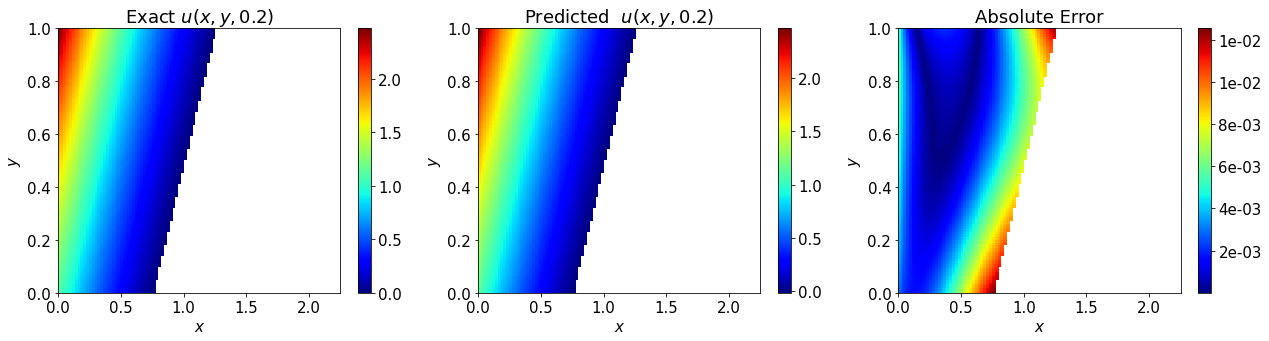

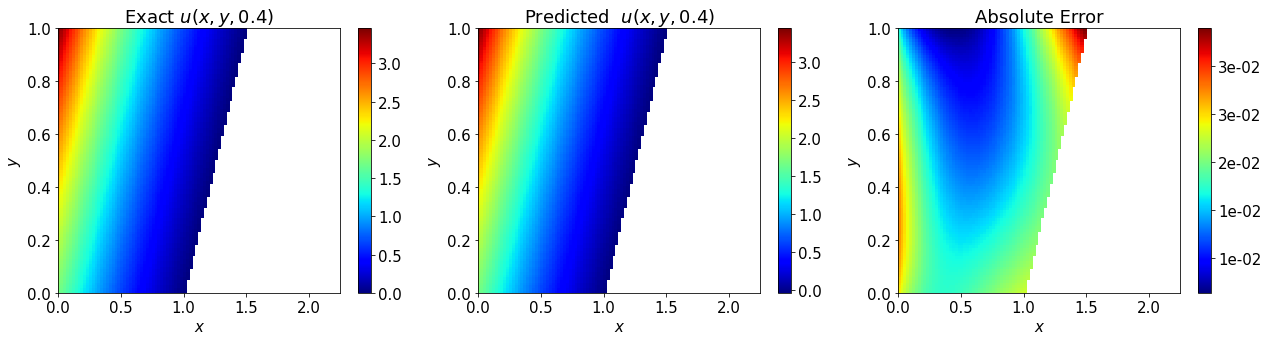

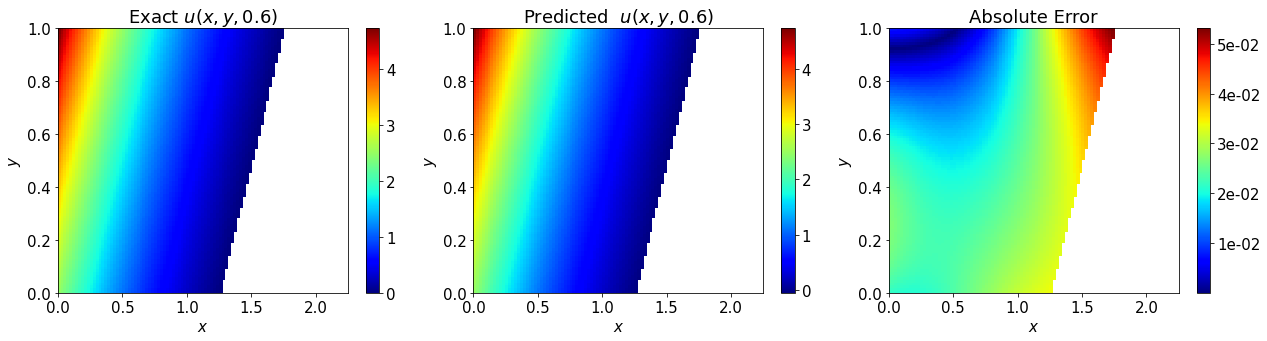

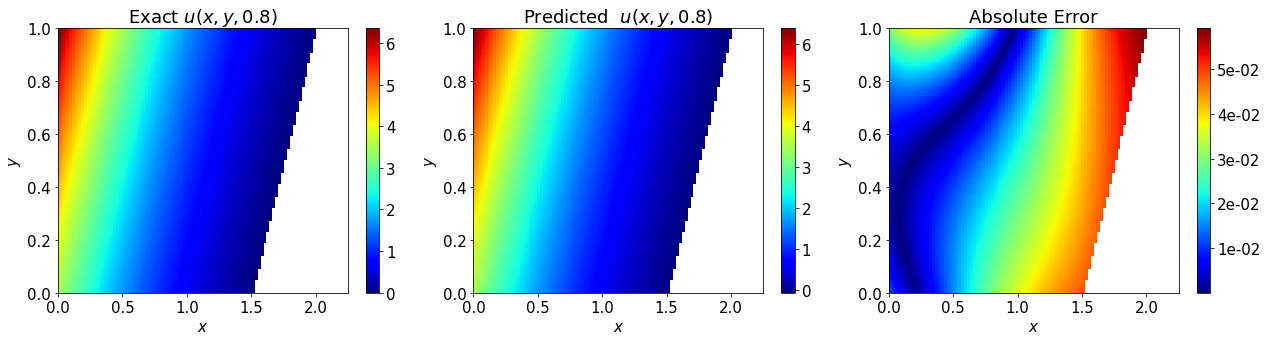

In [ ]:
import tensorflow as tf
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive')
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()
tf.reset_default_graph()
import gc
import matplotlib

font = {'size' : 15}

matplotlib.rc('font', **font)

if __name__ == '__main__':
    
    # Exact u
    def u(z):
        # x = (x, y, t)
        x = z[:, 0: 1]
        y = z[:, 1: 2]
        t = z[:, 2: 3]

        u =  np.exp(1.25 * t - x + 0.5 * y + 0.5) - 1
        return u

    # Exact s
    def s(z):
        y = z[:, 0: 1]
        t = z[:, 1: 2]
        s = 0.5 * y + 1.25 * t + 0.5
        return s
    
    # Initial condition u(x, y, 0) = exp(-x + y/2 + 1/2) -1
    def f(z):
        x = z[:, 0: 1]
        y = z[:, 1: 2]
        f = np.exp(- x + 0.5 * y + 0.5) -1
        return f

    def z(x):
        N = x.shape[0]
        return np.zeros((N, 1))

    # Domain boundaries
    ic_coords = np.array([[0.0, 0.0, 0.0],
                          [2.25, 1.0, 0.0]])
    
    bc1_coords = np.array([[0.0, 0.0, 0.0],
                           [2.25, 0.0, 1.0]])
    
    bc2_coords = np.array([[0.0, 0.0, 0.0],
                           [0.0, 1.0, 1.0]])
    
    bc3_coords = np.array([[0.0, 1.0, 0.0],
                           [2.25, 1.0, 1.0]])
    
    dom_coords = np.array([[0.0, 0.0, 0.0],
                           [2.25, 1.0, 1.0]])

    # Create Initial conditions samplers
    ics_sampler = Sampler(3, ic_coords, lambda x: f(x), name='Initial Condition')

    # Create boundary conditions samplers
    bc1_sampler = Sampler(3, bc1_coords, lambda x: u(x), name='Boundary Condition I')
    bc2_sampler = Sampler(3, bc2_coords, lambda x: u(x), name='Boundary Condition II')
    bc3_sampler = Sampler(3, bc3_coords, lambda x: u(x), name='Boundary Condition III')
    bcs_sampler = [bc1_sampler, bc2_sampler, bc3_sampler]

    # Create residual sampler
    res_sampler = Sampler(3, dom_coords, lambda x: u(x), name='Forcing')

    # Define model
    layers_u = [3, 100, 100, 100, 1]
    layers_s = [2, 100, 100, 100, 1]  


    # model = Stefan2D_direct(layers_u, layers_s, ics_sampler, bcs_sampler, res_sampler)

    #   # Train the model
    # model.train(nIter=1000, batch_size=128)
    for N in [100]:

      # Test data
      nn = N
      y = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
      t = np.linspace(dom_coords[0, 2], dom_coords[1, 2], nn)[:, None]
      y, t = np.meshgrid(y, t)
      
      X_star = np.hstack((y.flatten()[:, None], t.flatten()[:, None]))
      
      s_star = s(X_star)

      # Predictions
      s_pred = model.predict_s(X_star)
      
      error_s = np.linalg.norm(s_star - s_pred, 2) / np.linalg.norm(s_star, 2)
      print('The relative errror is: {:4e}'.format(error_s))
      if not os.path.exists('/content/drive/My Drive/Diploma/Test_1/'):
        os.mkdir('/content/drive/My Drive/Diploma/Test_1/')

      # Plot for s
      nn = N
      y = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
      t = np.linspace(dom_coords[0, 2], dom_coords[1, 2], nn)[:, None]
      y, t = np.meshgrid(y, t)

      X_star = np.hstack((y.flatten()[:, None], t.flatten()[:, None]))
      
      s_star = s(X_star)
      s_pred = model.predict_s(X_star)
      
      S_pred = griddata(X_star, s_pred.flatten(), (y, t), method='cubic')
      S_star = griddata(X_star, s_star.flatten(), (y, t), method='cubic')
          
      fig_1 = plt.figure(5, figsize=(18, 5))
      ax = fig_1.add_subplot(1, 3, 1, projection='3d')
      ax.plot_surface(y, t, S_star)
      ax.set_xlabel('y')
      ax.set_ylabel('t')
      ax.set_zlabel('s(y,t)')
      ax.set_title('Exact')
      
      ax = fig_1.add_subplot(1, 3, 2, projection='3d')
      ax.plot_surface(y, t, S_pred)
      ax.set_xlabel('y')
      ax.set_ylabel('t')
      ax.set_zlabel('s(y,t)')
      ax.set_title('Predicted')
      
      ax = fig_1.add_subplot(1, 3, 3, projection='3d')
      ax.plot_surface(y, t, np.abs(S_star - S_pred))
      ax.set_xlabel('y')
      ax.set_ylabel('t')
      ax.set_zlabel('s(y,t)')
      ax.set_title('Absolute Error')
      
      plt.tight_layout()
      with open('/content/drive/My Drive/Diploma/Test_1/Plot_for_S.pdf', 'w') as f:
            pass
      plt.savefig('/content/drive/My Drive/Diploma/Test_1/Plot_for_S.pdf')
      plt.clf()

      # Plot for u
      T_list = [0.2, 0.4, 0.6, 0.8]
      nn = N
      x = np.linspace(0, 2.25, nn)[:, None]
      y = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
      t = np.linspace(dom_coords[0, 2], dom_coords[1, 2], nn)[:, None]
      
      for T in T_list:
          X, Y = np.meshgrid(x, y)
          T_star = T * np.ones_like(X)
          X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T_star.flatten()[:, None]))
          
          u_star = u(X_star)
          u_pred = model.predict_u(X_star)
          
          X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))
          
          U_star = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')
          U_pred = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
          
          for i in range(nn):
              for j in range(nn):
                  X_ij = np.array([X[i,j], Y[i,j], T]).reshape(1,3)
                  u_ij = u(X_ij)
                  s_ij = s(np.array([Y[i,j], T]).reshape(1,2))
                  if X[i,j] > s_ij:
                      U_star[i,j] = np.nan
                      U_pred[i,j] = np.nan
      
          np.savetxt('pred_{}'.format(str(T)), U_pred, delimiter=',')
          np.savetxt('exact_{}'.format(str(T)), U_star, delimiter=',')
          
      
      for T in T_list:
          U_pred = np.loadtxt('pred_{}'.format(str(T)), delimiter=',')
          U_star = np.loadtxt('exact_{}'.format(str(T)), delimiter=',')
          
          fig = plt.figure(figsize=(18, 5))
          plt.subplot(1, 3, 1)
          plt.pcolormesh(X, Y, U_star, cmap='jet')
          plt.colorbar()
          plt.xlabel(r'$x$')
          plt.ylabel(r'$y$')
          plt.title('Exact $u(x, y, {})$'.format(T))
          
          plt.subplot(1, 3, 2)
          plt.pcolormesh(X, Y, U_pred, cmap='jet')
          plt.colorbar()
          plt.xlabel(r'$x$')
          plt.ylabel(r'$y$')
          plt.title('Predicted  $u(x, y, {})$'.format(T))
      
          plt.subplot(1, 3, 3)
          plt.pcolormesh(X, Y, np.abs(U_star - U_pred), cmap='jet')
          plt.colorbar(format='%.0e')
          plt.xlabel(r'$x$')
          plt.ylabel(r'$y$')
          plt.title('Absolute Error')
          
          plt.tight_layout()
          with open('/content/drive/My Drive/Diploma/Test_1/Plot_for_U[T={}].pdf'.format(T), 'w') as f:
            pass
          plt.savefig('/content/drive/My Drive/Diploma/Test_1/Plot_for_U[T={}].pdf'.format(T))


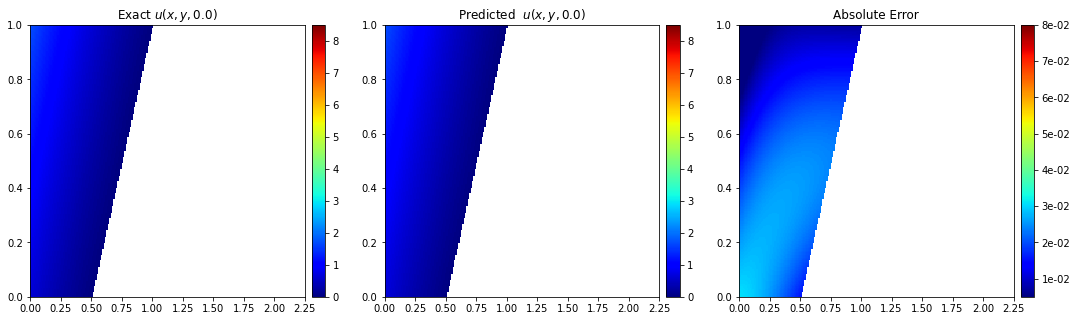

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig = plt.figure(figsize=(18, 5))

from mpl_toolkits.axes_grid1 import make_axes_locatable

ax1 = plt.subplot(1,3,1)   
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)



txt_title_1 = ax1.set_title('')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')

txt_title_2 = ax2.set_title('')
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$')

txt_title_3 = ax3.set_title('')
ax3.set_xlabel(r'$x$')
ax3.set_ylabel(r'$y$')

x = np.linspace(0, 2.25, 200)[:, None]
y = np.linspace(dom_coords[0, 1], dom_coords[1, 1], 200)[:, None]
t = np.linspace(dom_coords[0, 2], dom_coords[1, 2], 100)[:, None]

X, Y = np.meshgrid(x, y)
T_star = 0 * np.ones_like(X)
X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T_star.flatten()[:, None]))

u_star = u(X_star)
u_pred = model.predict_u(X_star)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

U_star = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')

for i in range(nn):
    for j in range(nn):
        X_ij = np.array([X[i,j], Y[i,j], T]).reshape(1,3)
        u_ij = u(X_ij)
        s_ij = s(np.array([Y[i,j], T]).reshape(1,2))
        if X[i,j] > s_ij:
            U_star[i,j] = np.nan
            
pcol_plot1 = ax1.pcolormesh(X, Y, U_star, cmap='jet', vmin=0, vmax=8.5)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.1)
plt.colorbar(pcol_plot1, cax=cax1)

pcol_plot2 = ax2.pcolormesh(X, Y, U_pred, cmap='jet', vmin=0, vmax=8.5)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.1)
plt.colorbar(pcol_plot2, cax=cax2)

pcol_plot3 = ax3.pcolormesh(X, Y, np.abs(U_star - U_pred), cmap='jet', vmin=0.005, vmax=0.08)
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('right', size='5%', pad=0.1)
plt.colorbar(pcol_plot3, cax=cax3, format='%.0e')

def animate(T):

  T = T[0]
  X, Y = np.meshgrid(x, y)
  T_star = T * np.ones_like(X)
  X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T_star.flatten()[:, None]))
  
  u_star = u(X_star)
  u_pred = model.predict_u(X_star)
  
  X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))
  
  U_star = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')
  U_pred = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')

  for i in range(nn):
    for j in range(nn):
        X_ij = np.array([X[i,j], Y[i,j], T]).reshape(1,3)
        u_ij = u(X_ij)
        s_ij = s(np.array([Y[i,j], T]).reshape(1,2))
        if X[i,j] > s_ij:
            U_star[i,j] = np.nan
            U_pred[i,j] = np.nan

  ax1.clear()
  ax2.clear()
  ax3.clear()

  pcol_plot1 = ax1.pcolormesh(X, Y, U_star, cmap='jet', vmin=0, vmax=8.5)

  pcol_plot2 = ax2.pcolormesh(X, Y, U_pred, cmap='jet', vmin=0, vmax=8.5)

  pcol_plot3 = ax3.pcolormesh(X, Y, np.abs(U_star - U_pred), cmap='jet', vmin=0.005, vmax=0.08)

  ax1.set_title('Exact $u(x, y, {})$'.format(np.round(T, 2)))
  ax2.set_title('Predicted  $u(x, y, {})$'.format(np.round(T, 2)))
  ax3.set_title('Absolute Error')


anim = FuncAnimation(fig, animate, frames=t, repeat=False, interval=20)
HTML(anim.to_html5_video())